In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Base

  Activating environment at `~/Documents/CMU-Projects/MRSD/Sem2/OCRL/Project/Project.toml`


In [183]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function ϕ(x)
    p = x[1:2]
    -(norm(p - [40,25])^2 - 2^2)     
    
end

function ∇ϕ(x)
    FD.gradient(ϕ, x)
end

function cbf(x::Vector,  # current state 
             u0::Vector, # nominal control input 
             A::Matrix,  # discrete time A 
             B::Matrix,  # discrete time B 
             dt::Real)   # time step size 
    
    # tune this (lower the number = more aggressive)
    λ = -10
    
    # our variable we are solving for 
    u = cvx.Variable(3)
    
    # approximate xdot
#     xdot = rk4(x, u, dt, diff_drive_dynamics)
    #take rk4 out of the function?
    
    xdot = ((A*x + B*u)-x)/dt
    
#     xdot = [u[1] + cos(x[3]), u[1] * sin(x[3]), u[2]]
    
    ϕdot = transpose(∇ϕ(x))*xdot
    
#     @show λ*ϕ(x)
#     @show  ϕdot

    
    # find the closest control to the given u0
    prob = cvx.minimize(cvx.sumsquares(u - u0))
    
    # must be safe  
    prob.constraints += [ϕdot <= λ*ϕ(x)]
    
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    return vec(u.value)
end
function circle()
    center = [40,25]
    rad = 2
    θs = range(0,2*pi,length = 100)
    points = [(rad*[cos(θ),sin(θ)]+center) for θ in θs]
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    x, y
end
    

circle (generic function with 1 method)

In [184]:
#robot dynamics
function diff_drive_dynamics(x, u)
    
    # state: x,y,phi
    # control: vx, ω
    
    Vx = u[1]
    ω = u[2]
    
    θ = x[3]
    ẋ = [Vx * cos(θ), Vx * sin(θ), ω]
    return ẋ
end


# vanilla RK4
function rk4(x::Vector, u, dt::Float64, dynamics::Function)
    k1 = dt * dynamics(x, u)
    k2 = dt * dynamics(x + k1/2, u)
    k3 = dt * dynamics(x + k2/2, u)
    k4 = dt * dynamics(x + k3, u)
    return x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end


# simulate dynamics 
function simulate_robot(xic, xg, xs, Kp, Kd, dt, tf)
    t_vec = 0:dt:tf 
    N = length(t_vec)

    #reference trajectory
    Xref = range(xs, xg, length=N)

    # init the p and d errors
    e_p = [zeros(3) for i in 1:N]
    e_d = zeros(3)

    #initialize state and control vector
    X = zeros(3, N)
    X[:, 1] = xic
    U = zeros(2, N-1)
    
    
    for i = 1:N-1
        # the proportional error is the current state minus the reference
        e_p[i] = X[:, i] - Xref[i]

        if i == 1
            e_d = zeros(3)
        else
            
            # addressing sign flipping issue
            function angle_subtraction(a::Real, b::Real)
                c = b - a
                if c > π
                    c -= 2π
                elseif c < -π
                    c += 2π
                end
                return c
            end
            
            θ_des = atan(Xref[i][2]-X[2,i], Xref[i][1]-X[1,i])
            θ = X[3,i]
            
            #calculate derivative error
            yaw_error = angle_subtraction(θ, θ_des)
            e_p[i][3] = yaw_error
            e_d = (e_p[i] - e_p[i-1]) / dt
                 
        end
        
        # form nominal control vector
        u0 = (Kp * e_p[i]) + (Kd * e_d)
        
        #modify with cbf
        A = FD.jacobian(dx -> rk4( dx, u0, dt, diff_drive_dynamics), X[:, i])  
        B = FD.jacobian(du -> rk4( X[:, i], du, dt, diff_drive_dynamics), u0)
        
        u = cbf(X[:,i],u0,A,B,dt) # modified safe control 
        
        #cbf before or after clipping?
        
#         U[:, i] = [sqrt(u0[1]^2 + u0[2]^2), u0[3]]
        
        U[:, i] = [sqrt(u[1]^2 + u[2]^2), u[3]]
        # limit control inputs
        #max linear speed 0-2 m/s
        #max angular speed -pi/3-pi/3
        
        if U[1, i][1] > 3
            U[1, i] = 3
        elseif U[1, i] < -3
            U[1, i] = -3
        end
        
        if U[2, i] > pi/3
            U[2, i] = pi/3
        elseif U[2, i] < -pi/3
            U[2, i] = -pi/3
        elseif U[2, i] < 1e-5
            U[2, i] = 0
        end
                
        X[:, i+1] = rk4(X[:, i], U[:, i], dt, diff_drive_dynamics)
    end
    
    return X, Xref, U, N, t_vec
end

simulate_robot (generic function with 1 method)

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Co

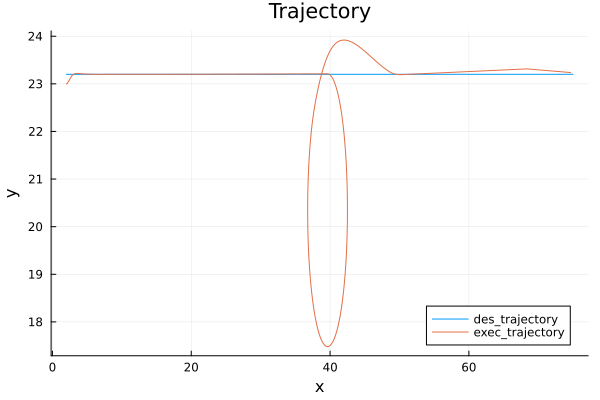

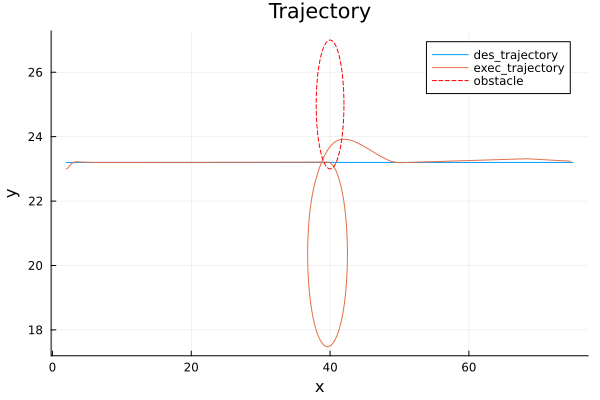

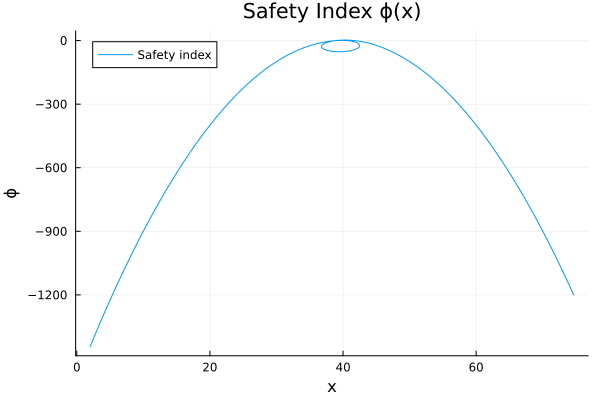

In [187]:

# set the goal states
xic = [2., 23, 0.] # initial condition

xg = [75., 23.2, 0.] # goal pos of desired traj
xs = [2., 23.2, 0.] # start pos of desired traj


# set the P and D matrices
Kp = 3*[1 0 0; 0 1 0; 0 0 1]
Kd = [1 0 0; 0 1 0; 0 0 1]

# simulation parameters
dt = 0.02
tf = 70.0

X, Xref, U, N, t_vec = simulate_robot(xic, xg, xs, Kp, Kd, dt, tf)

refx = [Xref[i][1] for i = 1:N]
refy = [Xref[i][2] for i = 1:N]
simx = [X[1, i] for i = 1:N]
simy = [X[2, i] for i = 1:N];

x, y = circle()
plot(refx, refy, label  = "des_trajectory", xlabel = "x", ylabel = "y", title = "Trajectory")
display(plot!(X[1,:],X[2,:], label  = "exec_trajectory", xlabel = "x", ylabel = "y", title = "Trajectory"))
display(plot!(x,y,lc = :red, ls = :dash,label = "obstacle"))

ϕs = Vector{Float64}(undef, N)
for i=1:N
    ϕs[i] = ϕ(X[:,i])
end

plot(X[1,:],ϕs,label="Safety index", xlabel = "x", ylabel = "ϕ", title = "Safety Index ϕ(x)")
